In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Load the processed dataset
df = pd.read_csv("processed_sales_data.csv")

# Display the first few rows
print(df.head())

         Date  Product_ID  Quantity_Sold      Price  Promotion  Holiday  \
0  2023-01-01           0             31  24.041678          0        0   
1  2023-01-02           0              1  87.394637          0        0   
2  2023-01-03           0             62  63.810998          1        0   
3  2023-01-04           0              9  74.955657          0        0   
4  2023-01-05           0             18  39.191052          0        0   

   Month  Year  Week_of_year  Lag_7  ...  Rolling_Std_7  Price_Change  \
0      1  2023            52    0.0  ...       0.000000      0.000000   
1      1  2023             1    0.0  ...      21.213203     63.352959   
2      1  2023             1    0.0  ...      30.501366    -23.583639   
3      1  2023             1    0.0  ...      27.293162     11.144659   
4      1  2023             1    0.0  ...      23.889328    -35.764605   

   Promotion_Holiday  Day_0  Day_1  Day_2  Day_3  Day_4  Day_5  Day_6  
0                  0  False  False  Fa

C:\Users\Iworld\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


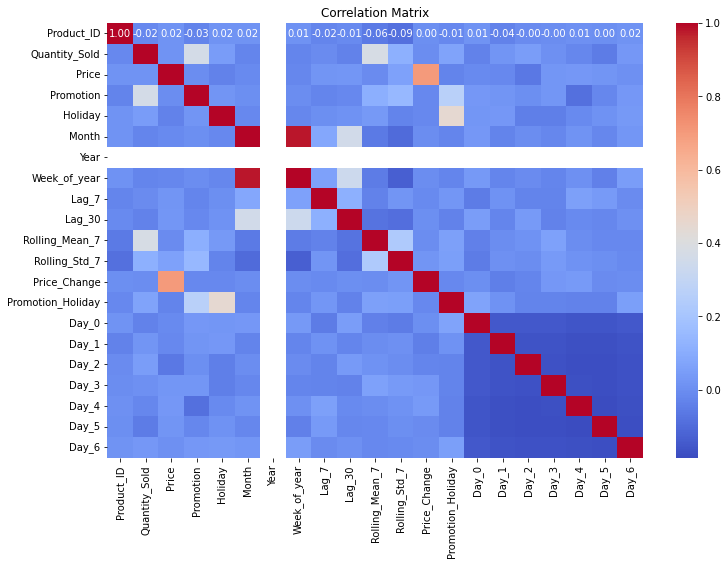

In [3]:
# Compute the correlation matrix
df1 = df.drop(columns=['Date'])
correlation_matrix = df1.corr()

# Plot the correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

In [4]:
# Correlation with the target variable
target_correlation = correlation_matrix['Quantity_Sold'].sort_values(ascending=False)
print("Correlation with Quantity_Sold:")
print(target_correlation)

Correlation with Quantity_Sold:
Quantity_Sold        1.000000
Rolling_Mean_7       0.376260
Promotion            0.362867
Rolling_Std_7        0.115597
Promotion_Holiday    0.068659
Day_2                0.049285
Holiday              0.043232
Day_6                0.031803
Day_1                0.019955
Price                0.014432
Day_3                0.007992
Price_Change        -0.002200
Lag_7               -0.006289
Product_ID          -0.017088
Day_4               -0.021089
Week_of_year        -0.022863
Month               -0.024675
Lag_30              -0.033998
Day_0               -0.036173
Day_5               -0.051557
Year                      NaN
Name: Quantity_Sold, dtype: float64


In [5]:
# Define features and target
X = df.drop(columns=['Date', 'Quantity_Sold'])  # Features
y = df['Quantity_Sold']  # Target (demand)

In [6]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
# Define the XGBoost model
model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

# Define the parameter grid for Grid Search
param_grid = {
    'n_estimators': [50, 100, 200],  # Number of trees
    'learning_rate': [0.01, 0.1, 0.2],  # Learning rate
    'max_depth': [3, 5, 7],  # Maximum depth of trees
    'subsample': [0.8, 0.9, 1.0],  # Subsample ratio
    'colsample_bytree': [0.8, 0.9, 1.0]  # Feature subsample ratio
}

In [9]:
# Initialize Grid Search
from sklearn.model_selection import GridSearchCV
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='neg_mean_absolute_error',  # Use MAE for evaluation
    cv=5,  # 5-fold cross-validation
    verbose=1,  # Print progress
    n_jobs=-1  # Use all available CPU cores
)

# Perform Grid Search
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits


C:\Users\Iworld\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
1 fits failed out of a total of 1215.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Iworld\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Iworld\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
  File "C:\Users\Iworld\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\sklearn.py", li

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=42, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.8, 0.9, 1.0],
                         'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 5, 7], 'n_estimators': [50, 100, 200],
                         'subsample': [0.8, 0.9, 1.0]},
             scoring='neg_mean_absolute_error', verbose=1)

In [10]:
# Best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best MAE Score:", -grid_search.best_score_)  # Convert back to positive MAE

Best Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}
Best MAE Score: 10.768311821495354


In [11]:
# Train the model with the best parameters
best_model = grid_search.best_estimator_
best_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=1.0, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [12]:
# Make predictions on the test set
y_pred = best_model.predict(X_test)

In [13]:
# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

Mean Absolute Error (MAE): 11.02
Root Mean Squared Error (RMSE): 13.22


In [14]:
# Feature importance
feature_importance = best_model.feature_importances_
feature_names = X.columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

print("\nFeature Importance:")
print(importance_df)


Feature Importance:
              Feature  Importance
2           Promotion    0.233353
9      Rolling_Mean_7    0.109846
10      Rolling_Std_7    0.077151
1               Price    0.056708
12  Promotion_Holiday    0.046807
6        Week_of_year    0.045626
11       Price_Change    0.044822
15              Day_2    0.043437
7               Lag_7    0.042552
18              Day_5    0.041236
16              Day_3    0.038826
8              Lag_30    0.038744
3             Holiday    0.038308
4               Month    0.035373
0          Product_ID    0.030928
17              Day_4    0.028143
14              Day_1    0.025801
19              Day_6    0.022339
13              Day_0    0.000000
5                Year    0.000000


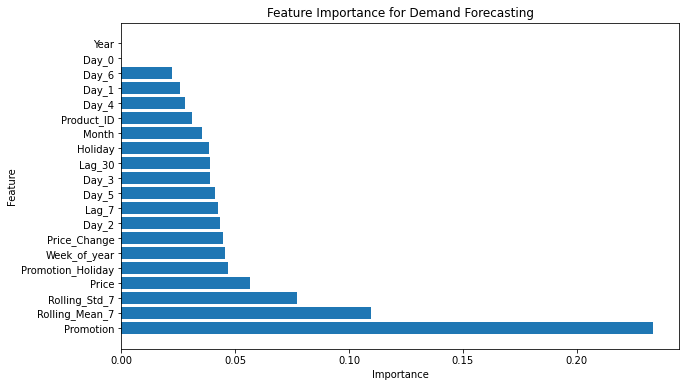

In [15]:

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance for Demand Forecasting')
plt.show()

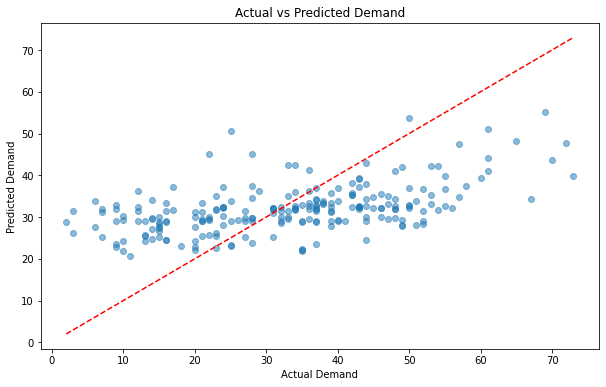

In [16]:
# Plot actual vs predicted demand
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')  # Diagonal line
plt.xlabel('Actual Demand')
plt.ylabel('Predicted Demand')
plt.title('Actual vs Predicted Demand')
plt.show()

In [17]:
import joblib

# Save the model
joblib.dump(model, "demand_forecasting_model.pkl")

# Load the model (for future use)
# loaded_model = joblib.load("demand_forecasting_model.pkl")

['demand_forecasting_model.pkl']